# Recommendation System via a Gaussian Mixture Model and the EM algorithm for Matrix Completion

We build the entire model using only Numpy.

In [1]:
import numpy as np

## The Data

First we import our partially observed data matrix X along with the complete matrix which we will use as the ground truth to compare to later.

In [2]:
X = np.loadtxt('netflix_incomplete.txt')
X_complete = np.loadtxt('netflix_complete.txt')

We extract some fixed parameters from our data for convenience. 

In [3]:
# n: number of users, d: number of movies
n, d = X.shape

# K: number of clusters/Gaussians
K = 12

# delta: matrix indicating missing reviews
delta = np.where(X == 0,0,1)

## The Expectation Maximization (EM) Algorithm

First we initialize the parameters of our mixture.

In [4]:
# mu: d-dimensional mean for each Gaussian
np.random.seed(1)
mu = X[np.random.choice(n, K, replace = False)]

# p: weights for each Gaussian
p = np.ones(K)/K

# var: 1-dimensional variance for each Gaussian
var = np.sum((mu*np.ones([n,K,d]) - X.reshape([n,1,d]))**2, axis=(0,2))/(n*d)

We define a function for computing the squared norm which depends only on the current mu.

In [5]:
def compute_norm(mu):
    U = (mu*np.ones([n,K,d]))*delta.reshape([n,1,d])
    sub_stack = U - X.reshape([n,1,d])
    return np.sum(sub_stack**2, axis = 2)

### The E-step

We define a function which runs the E-Step of the EM algorithm returning the soft counts (posterior) and the log-likelihood of the assignment.

In [6]:
def estep(X,mu,p,var):
    
    norm = compute_norm(mu)
    
    C_u = np.sum(delta,axis=1,keepdims=True)
    logged_gauss = np.log(p) - C_u/2*np.log(2*np.pi*var*np.ones([n,K])) - norm/(2*var)
    max_vector = np.amax(logged_gauss, axis=1, keepdims=True)
    scaled_gauss = np.exp(logged_gauss - max_vector)
    denom = max_vector + np.log(np.sum(scaled_gauss, axis=1, keepdims=True))
    
    log_post = logged_gauss - denom
    log_likelihood = np.sum(denom)
    
    return np.exp(log_post), log_likelihood

### The M-step

We define a function which runs the M-Step of the EM algorithm returning the updated mixture.

In [7]:
def mstep(X, post, min_var, mu, p, var):
    
    norm = compute_norm(mu)
    
    #update mu
    mu_numer = np.dot(X.T, post).T
    mu_denom = np.dot(delta.T, post).T
    mu = np.where(mu_denom >= 1, mu_numer/(mu_denom +1e-10), mu)
    
    #update var
    C_u = np.sum(delta, axis=1, keepdims=True)
    sum_factor = np.sum(post*norm, axis = 0)
    first_factor = 1/np.sum(C_u*post, axis = 0)
    var_bad = first_factor*sum_factor
    var = np.where(var_bad < min_var, min_var, var_bad)
    
    #update p
    p = np.sum(post, axis = 0)/n
    
    #update norm
    norm = compute_norm(mu)
    
    return mu,p,var

### Running the EM Algorithm

We define a function which runs the entire EM algorithm using our E-step and M-step functions.

In [8]:
def run(X, mu, p ,var, min_var=.1):
    
    history = []
    old_log = None
    new_log = None
    while old_log is None or (new_log - old_log > 1e-6*np.abs(new_log)):
        old_log=new_log
        
        #E-step
        post, new_log = estep(X, mu, p, var)
        history.append(new_log)
        
        #M-step
        mu, p, var = mstep(X, post, min_var, mu, p, var)
    
    return mu, p,var, post, new_log, history
        
mu, p, var, _, _, history = run(X, mu, p, var, 0.1)

### Plotting the Log-Likelihood

We will use MatPlotLib to plot the log-likelihood and confirm that our log-likelihood is increasing and shows signs of convergence.

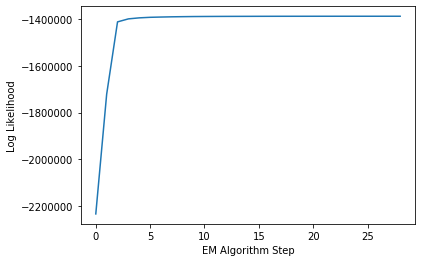

In [9]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.ylabel('Log Likelihood')
plt.xlabel('EM Algorithm Step')
plt.show()

## Matrix Completion

Next, we use our mixture to "fill" the incomplete matrix.

In [10]:
def fill(X,mu,p,var):
    
    post,_ = estep(X,mu,p,var)
    X_pred = X.copy()
    miss_indices = np.where(X == 0)
    X_pred[miss_indices] = (post@mu)[miss_indices]
    
    return X_pred

X_filled = fill(X,mu,p,var)

## Evaluating our Model

Finally we calculate the rmse between the complete and incomplete matrix. (It is important to know that the completed matrix was not used at all up to this point as in real world applications, we would not have access to that data.)

In [11]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))

print('RMSE of the original incomplete matrix and the complete matrix is ', rmse(X, X_complete))
print('RMSE of the newly-filled matrix and the complete matrix is ', rmse(X_filled, X_complete))

RMSE of the original incomplete matrix and the complete matrix is  1.6787480867863673
RMSE of the newly-filled matrix and the complete matrix is  0.48253399427052135


The RMSE is much lower, meaning that our filled matrix is now much closer to the completed matrix, the "ground truth", and is a good predictor of how much a viewer would enjoy a movie which they have not previously watched.